In [5]:
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
b32 = 2**32-1
b64 = 2**64-1

# Map of asset to maximum nonce value, used later for plotting
assets_to_range = {
    "btc": b32,
    "bch": b32,
    "vtc": b32,
    "ltc": b32, 
    "xmr": b32, 
    "dcr": b32, 
    "grin": b64,
    "eth": b64,
    "etc": b64,
    "xvg": b32,
    "dgb": b32,
}

# given a number, return a list of n bits ([0, 1, 1, ...])
def to_bits(number, n):
    return [int(x) for x in bin(number)[2:].zfill(n)]

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [7]:
from math import log

def query_nonces(table):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT nonce FROM {table} ORDER BY height ASC")
            return list(map(lambda x: int(x[0]), cursor.fetchall()))

def get_ethereum_nonces(table):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT ENCODE(nonce, 'hex') FROM {table} ORDER BY number ASC")
            return list(map(lambda x: int(x[0], 16), cursor.fetchall()))
        
def get_nonces(asset):
    if asset == "btc":
        return query_nonces("bitcoin")
    elif asset == "ltc":
        return query_nonces("litecoin")
    elif asset == "xmr":
        return query_nonces("monero")
    elif asset == "dcr":
        return query_nonces("decred")
    elif asset == "grin":
        return query_nonces("grin")
    elif asset == "eth":
        return get_ethereum_nonces("ethereum")
    elif asset == "etc":
        return get_ethereum_nonces("ethereum_classic")
    elif asset == "xvg":
        return query_nonces("verge")
    elif asset == "vtc":
        return query_nonces("vertcoin")
    elif asset == "bch":
        return query_nonces("bitcoin_abc")
    elif asset == "dgb":
        return query_nonces("digibyte")
        
    raise NotImplementedError(asset)

In [8]:
nonces = {symbol: get_nonces(symbol) for symbol in assets_to_range.keys()}

In [9]:
sns.set(rc={'figure.figsize':(10,4), 'figure.dpi': 100})

def plot_distribution(asset, n_bins=200):
    sns.set_style("white")
    
    plt.title(f"{asset} nonce histogram")
    max_x = assets_to_range[asset]
    data = nonces[asset]
    plt.xlim(0, max_x)
    ax = sns.distplot(data, kde=False, bins=n_bins, hist_kws={"histtype": "bar", "color": "b"})
    # We need to compute the expected number of blocks per bin
    # and display it as a horizontal line
    n_expected_blocks = len(data) / n_bins
    ax.axhline(y=n_expected_blocks, xmin=0.0, xmax=1, color='r', ls='--', lw=1)
    plt.xlabel("Nonce value")
    plt.ylabel("# of blocks")
    plt.show()
    
def plot(asset, alpha=None):
    max_x = assets_to_range[asset]
    data = nonces[asset]
    
    # for forks, we put a vertical bar at the fork height
    fork_height = {
        "bch": 478559,
        "bsv": 556766,
        "etc": 1920000,
    }
    
    n_blocks = len(data)
    # Simple heuristic to have a somewhat correct alpha no matter the density
    alpha_value = n_blocks / 10000000. if alpha is None else alpha
    plt.figure(figsize=(10,4), dpi=100)
    plt.xlabel("Block height")
    plt.ylabel("Nonce value")
    plt.title(f"{asset} nonce distribution")
    plt.ylim(0, max_x)
    plt.xlim(0, n_blocks)
    plt.plot(data, ',', alpha=alpha_value)
    if asset in fork_height:
        plt.axvline(fork_height[asset], 0, 1, color='r', ls='solid', lw=1)
        
    plt.show()
    
def heatmap_annotated(asset, bin_size):
    if asset == "eth":
        bits = 64
    else:
        bits = 32
        
    heatmap(nonces[asset], bin_size, bits)
    
    if asset == "eth":
        # Bitmain E3 ASIC announcement
        plt.axvline(5370000 / bin_size, color='r', ls='--', lw=1)
        # Bitmain E3 ASIC first shipments
        plt.axvline(5970000 / bin_size, color='r', ls='-', lw=1)
    elif asset == "btc":
        # Bitmain S9 ASIC announcement
        plt.axvline(414136 / bin_size, color='r', ls='--', lw=1)
        # Bitmain S9 ASIC first shipments
        plt.axvline(5970000 / bin_size, color='r', ls='-', lw=1)

def heatmap(nonces, bin_size, bits):
    sns.set_style("white")

    data = []
    # split nonces into bin_size chunks
    for chunk in chunks(nonces, bin_size):
        n = len(chunk)
        # row collects how many time bits are set
        row = [0] * bits
        for nonce in chunk:
            # transform nonce into bit representation
            binary = to_bits(nonce, bits)
            # and collect when bits are set
            for i, bit in enumerate(binary):
                row[i] += bit
        # transform the row into %
        row = [i / n for i in row[:-1]]
        data.append(row)
        
    ax = sns.heatmap(np.array(data).T, xticklabels=False, cmap='Greys')
    n_blocks = len(nonces)
    ax.set_xticks([x * len(nonces) / (5 * bin_size) for x in range(5)])
    ax.set_xticklabels([int(x * len(nonces) / 5) for x in range(5)], fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8)

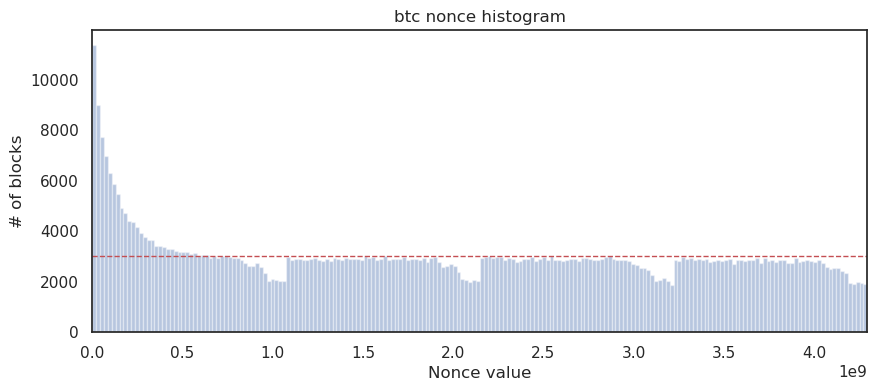

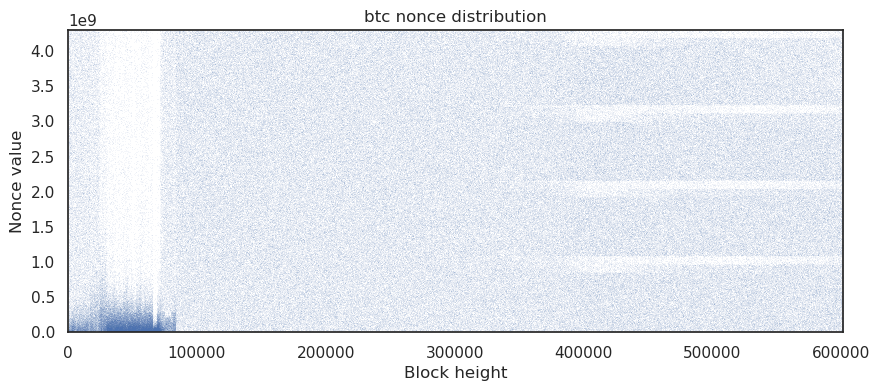

In [10]:
plot_distribution("btc")
plot("btc")

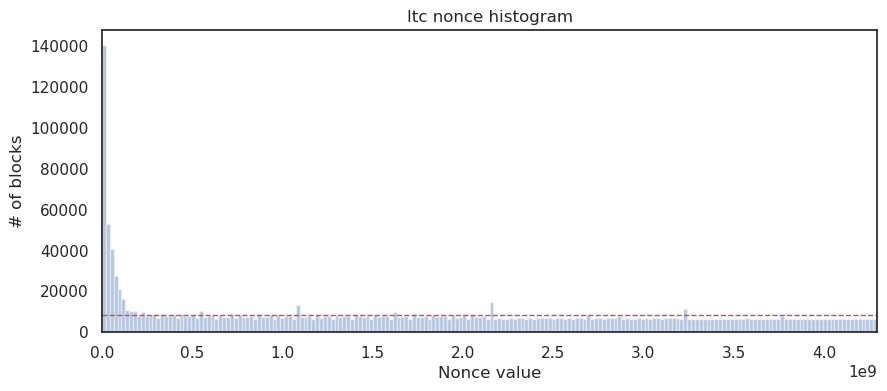

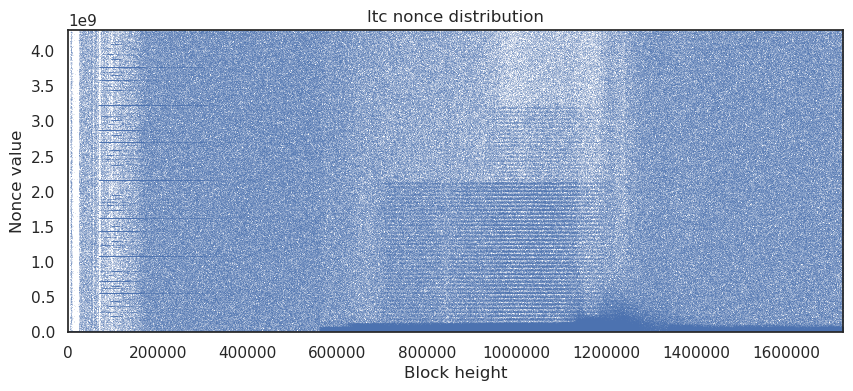

In [11]:
plot_distribution("ltc")
plot("ltc")

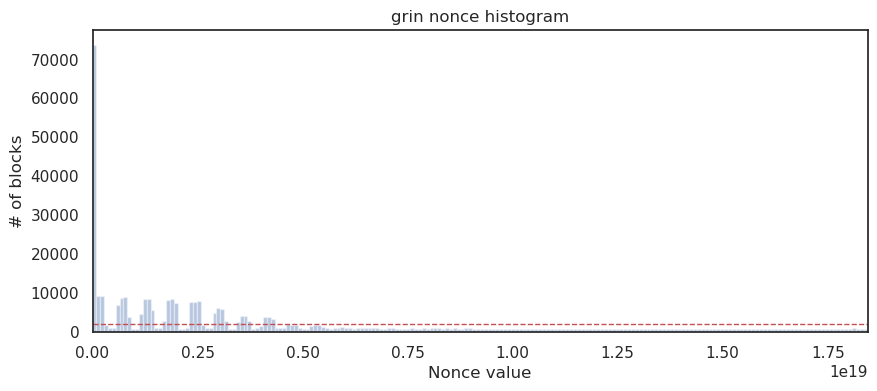

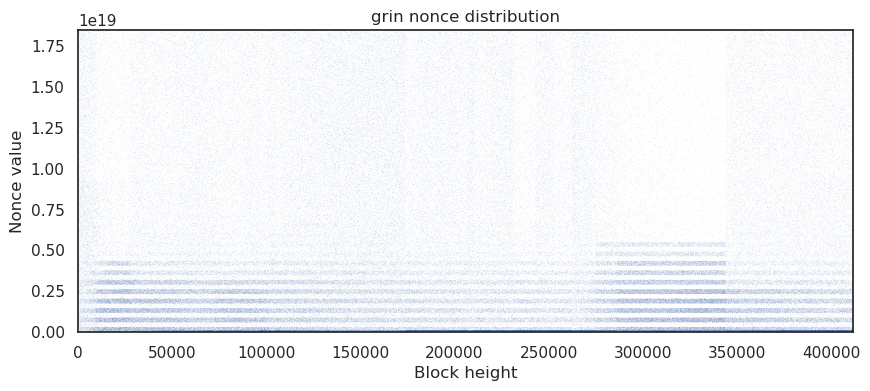

In [12]:
plot_distribution("grin")
plot("grin")

In [13]:
def get_xmr_diff():
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT difficulty FROM monero ORDER BY height ASC")
            return list(map(lambda x: int(x[0]), cursor.fetchall()))

xmr_diff = get_xmr_diff()

<Figure size 2000x800 with 0 Axes>

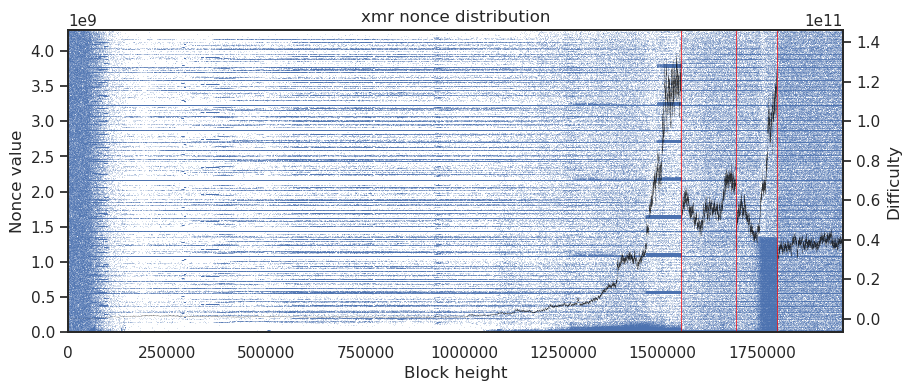

In [14]:
max_x = assets_to_range["xmr"]
data = nonces["xmr"]

n_blocks = len(data)
# Simple heuristic to have a somewhat correct alpha no matter the density
alpha_value = n_blocks / 10000000

sns.set_style("white")

plt.figure(figsize=(20,8), dpi=100)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Block height")
ax1.set_ylabel("Nonce value")
ax2.set_ylabel("Difficulty")
plt.title("xmr nonce distribution")
ax1.set_ylim(0, max_x)
plt.xlim(0, n_blocks)

ax1.plot(data, ',', alpha=alpha_value)
ax2.plot(xmr_diff, '--', color='black', lw=0.1, alpha=0.75)

heights = [1546000, 1685555, 1788000]
for h in heights:
    plt.axvline(h, 0, 1, color='red', lw=0.5)

plt.show()

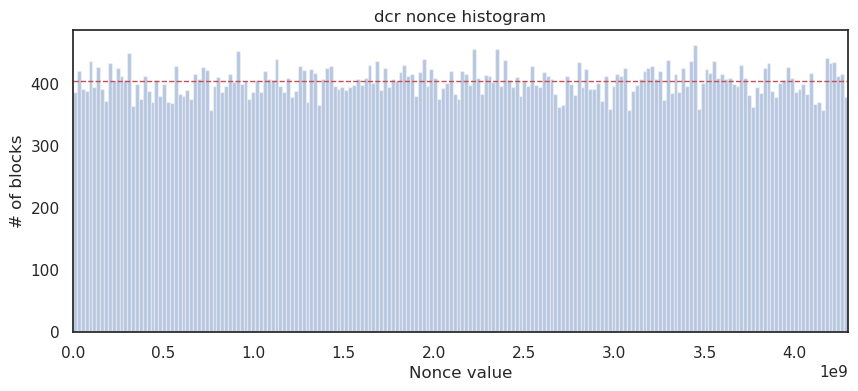

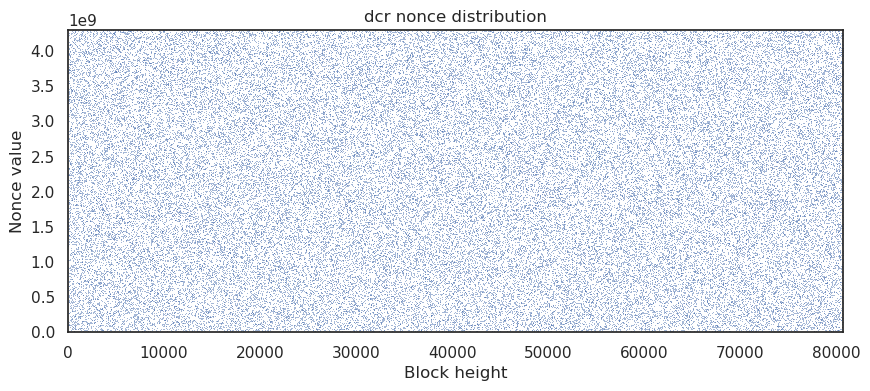

In [15]:
plot_distribution("dcr")
plot("dcr", alpha=0.5)

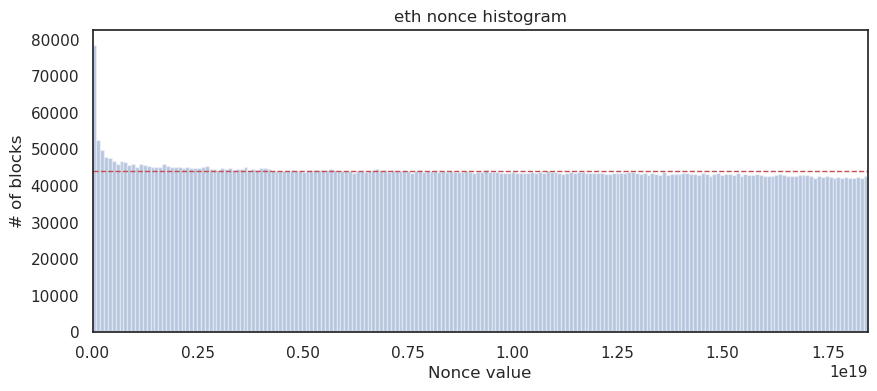

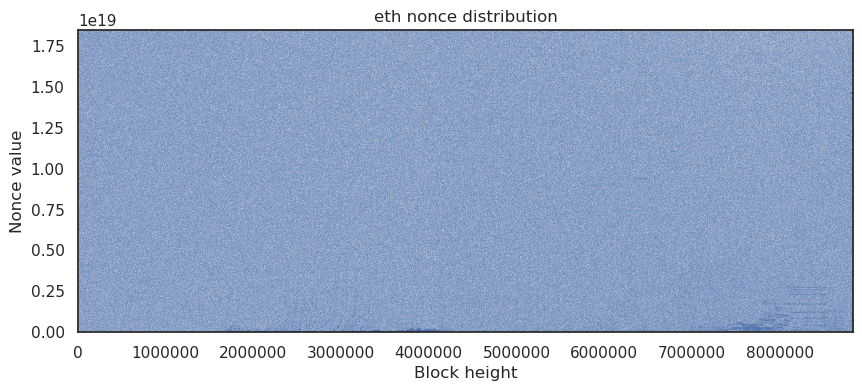

In [16]:
plot_distribution("eth")
plot("eth", alpha=0.025)

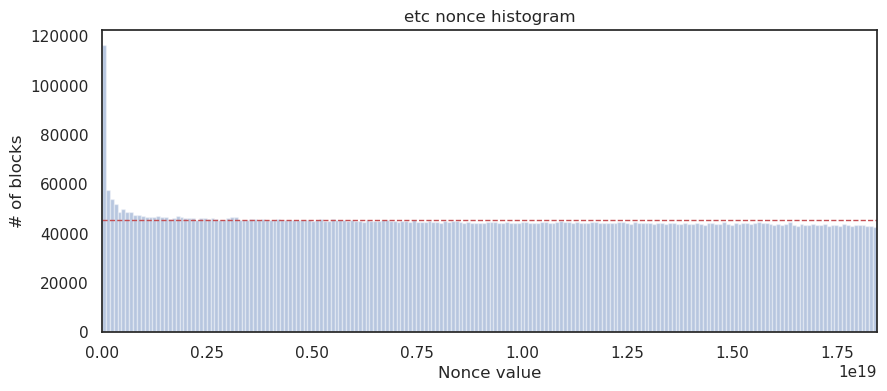

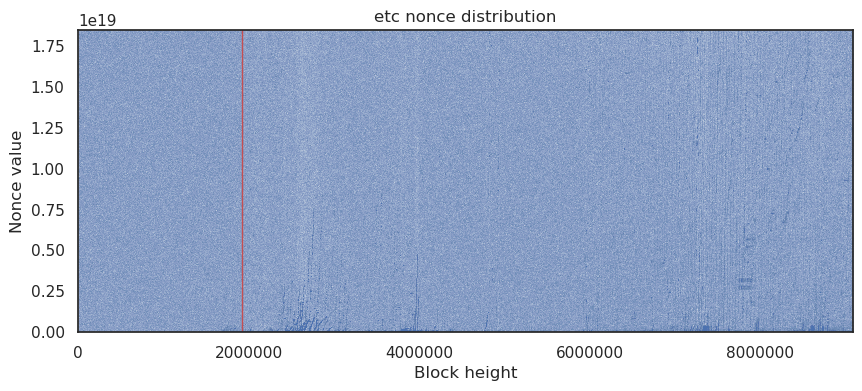

In [17]:
plot_distribution("etc")
plot("etc", alpha=0.025)

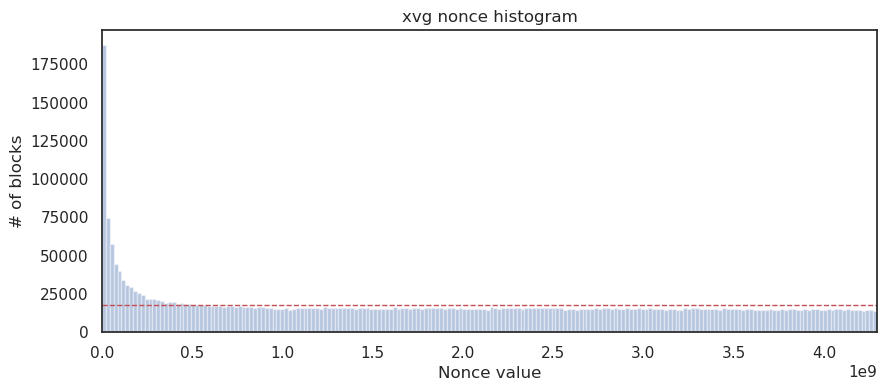

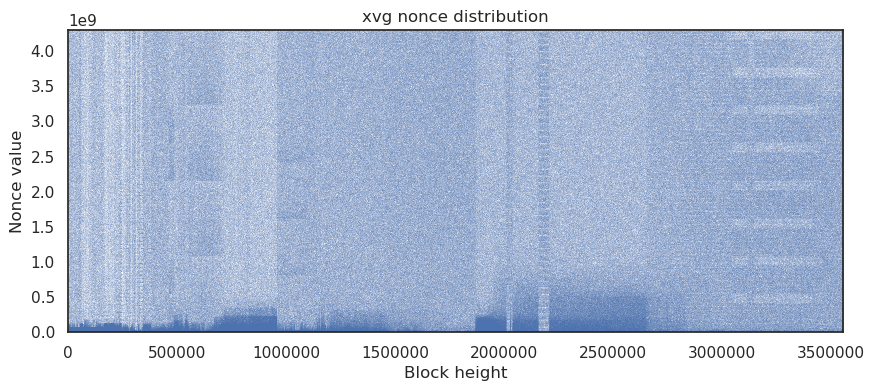

In [18]:
plot_distribution("xvg")
plot("xvg", alpha=0.05)

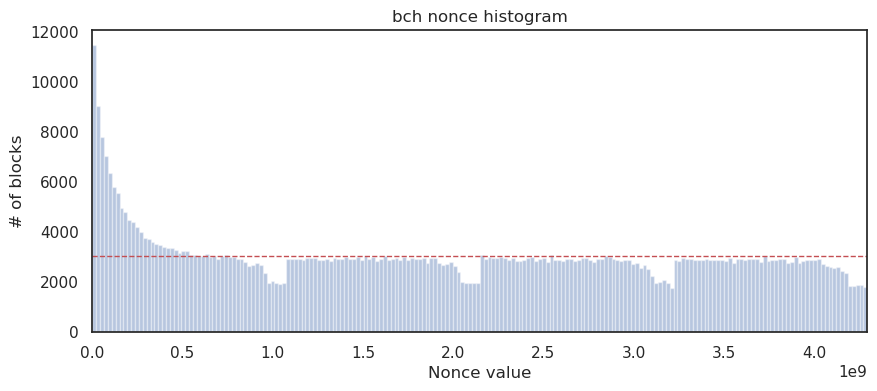

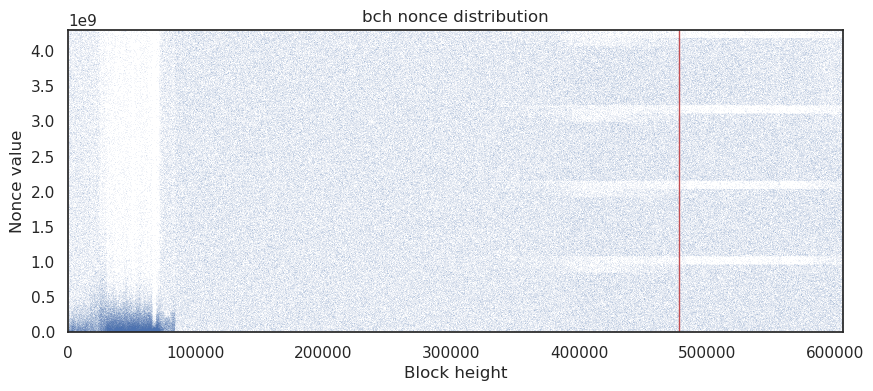

In [19]:
plot_distribution("bch")
plot("bch")

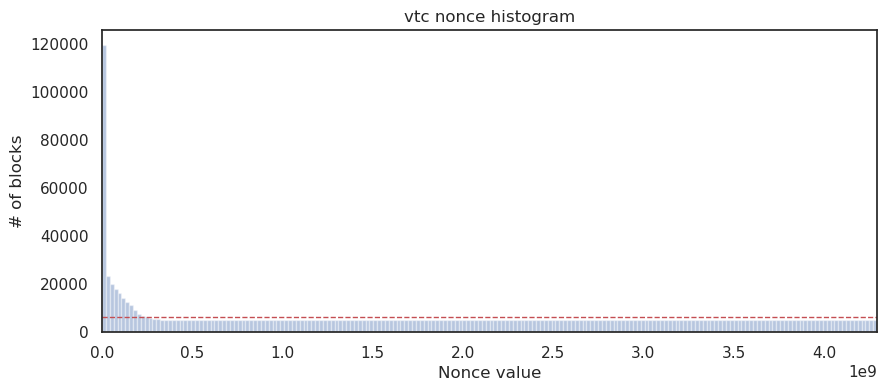

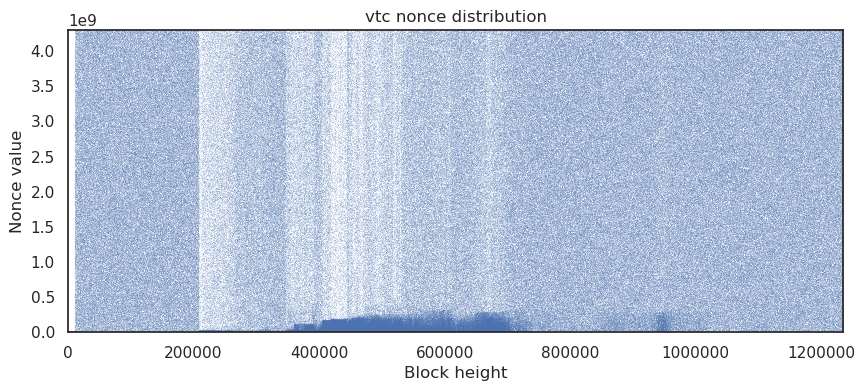

In [20]:
plot_distribution("vtc")
plot("vtc")

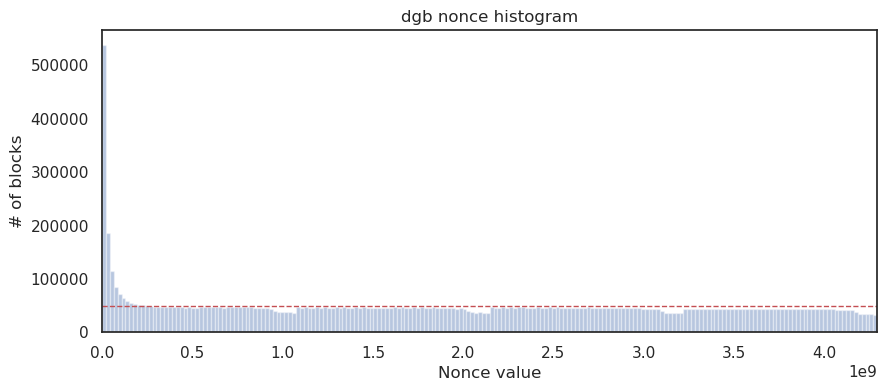

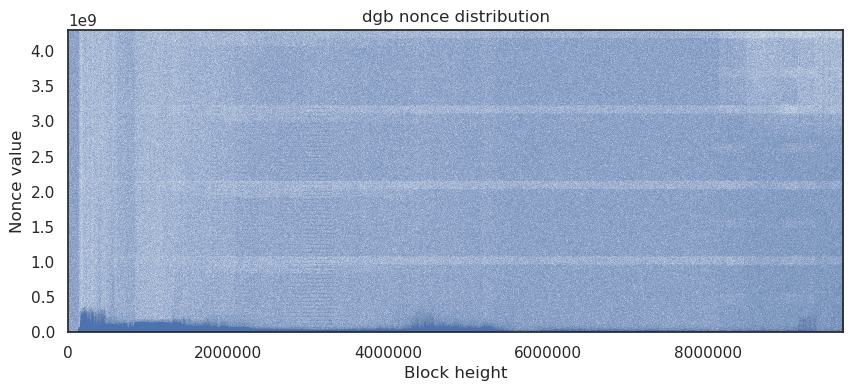

In [21]:
plot_distribution("dgb")
plot("dgb", alpha=0.02)

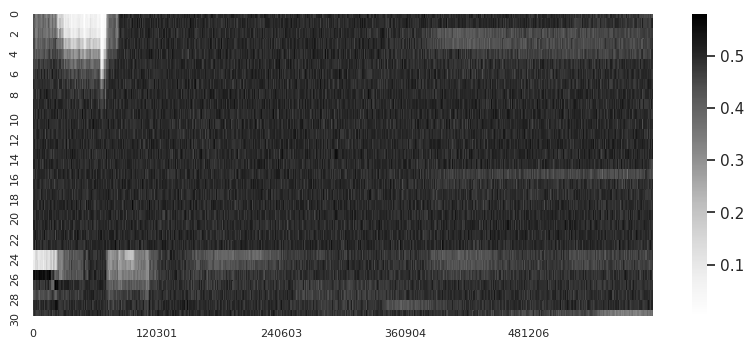

In [22]:
heatmap(nonces["btc"], 1000, 32)

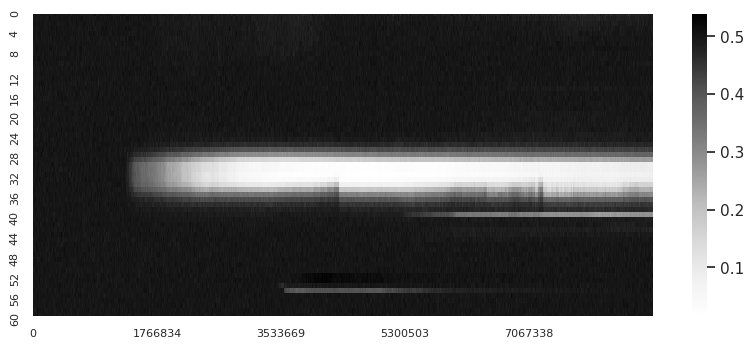

In [23]:
heatmap(nonces["eth"], 10000, 64)

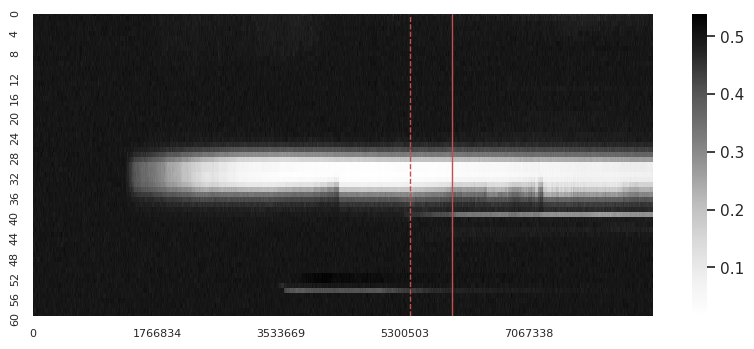

In [24]:
heatmap_annotated("eth", 10000)

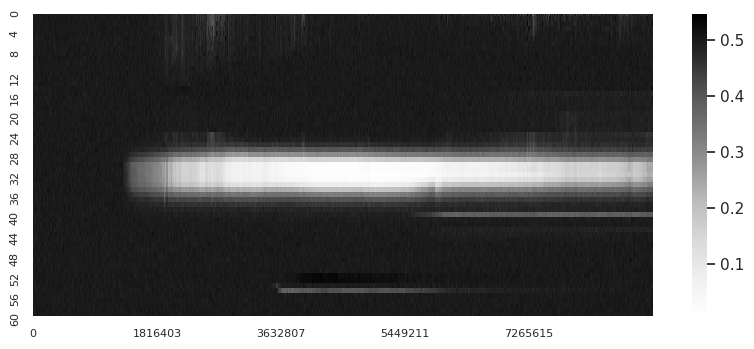

In [25]:
heatmap(nonces["etc"], 10000, 64)

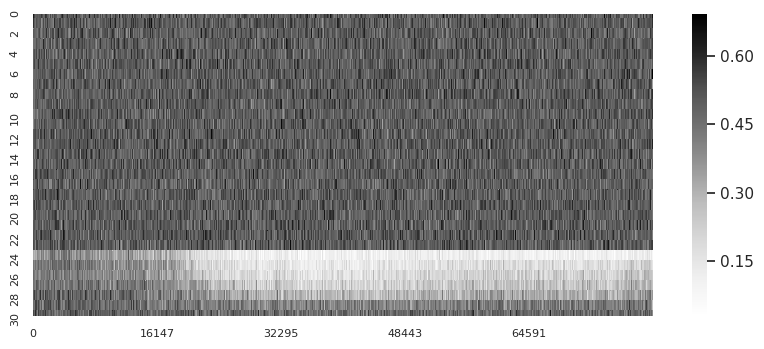

In [26]:
heatmap(nonces["dcr"], 100, 32)

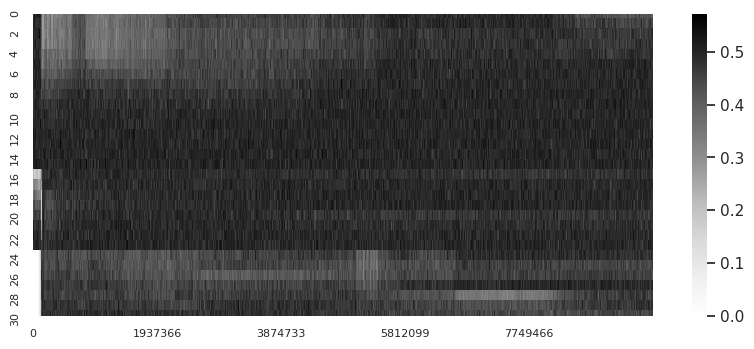

In [27]:
heatmap(nonces["dgb"], 1000, 32)

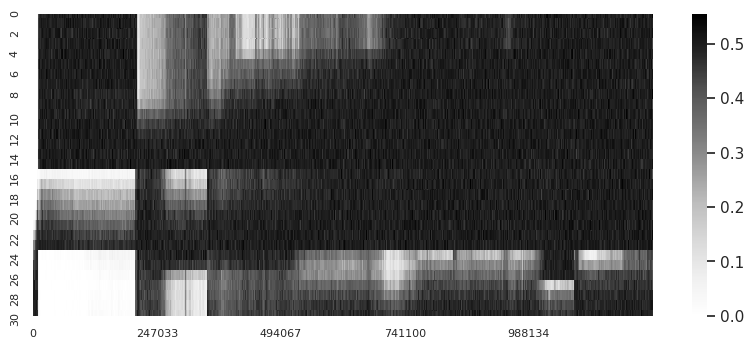

In [28]:
heatmap(nonces["vtc"], 1000, 32)

In [29]:
import struct

lower_bytes = list(map(lambda x: int(struct.pack('>I', x)[3]), nonces["dcr"]))

In [30]:
import statistics

statistics.mean(lower_bytes)

55.50596366068443

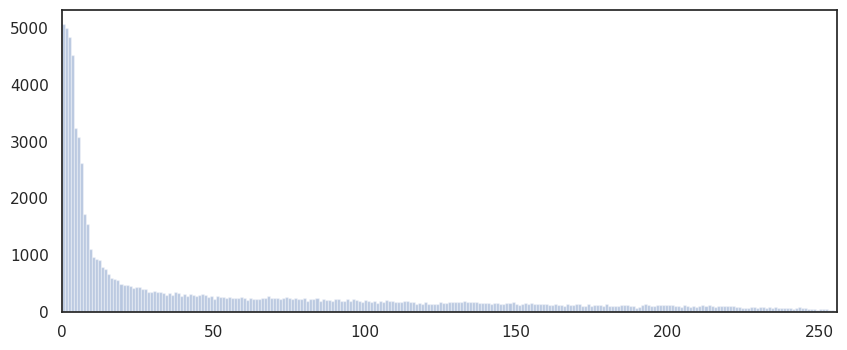

In [31]:
plt.xlim(0, 256)
ax = sns.distplot(lower_bytes, kde=False, bins=256)

In [32]:
import requests

genesis_zec_hash = "0007bc227e1c57a4a70e237cad00e7b7ce565155ab49166bc57397a26d339283"
batch_size = 2000

def get_zec_nonce_data(block_hash):
    url = f"http://localhost:8232/rest/headers/{batch_size}/{block_hash}.json"
    r = requests.get(url)
    return r.json()

zec_nonces = []
n_headers = batch_size
current_hash = genesis_zec_hash

while current_hash is not None:
    data = get_zec_nonce_data(current_hash)
    zec_nonces += [int(h["nonce"], 16) for h in data]
    current_hash = data[-1].get("nextblockhash", None)

ConnectionError: HTTPConnectionPool(host='localhost', port=8232): Max retries exceeded with url: /rest/headers/2000/0007bc227e1c57a4a70e237cad00e7b7ce565155ab49166bc57397a26d339283.json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f4bbccc6278>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
heatmap(zec_nonces, 1000, 256)

In [ ]:
height_window = 500

def get_avg_zec_diff(window):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"SELECT AVG(difficulty) FROM zcash GROUP BY height / {window} ORDER BY height / {window} ASC")
            return list(map(lambda x: float(x[0]), cursor.fetchall()))
        
zec_diff = get_avg_zec_diff(height_window)

In [36]:
def transpose(l):
    return list(map(list, zip(*l)))

In [ ]:

def get_zec_bit_data():
    zec_bits = []
    
    # split nonces into chunks
    for chunk in chunks(zec_nonces, height_window):
        chunk_bits = [0] * 256
        chunk_size = len(chunk)
        for nonce in chunk:
            # transform nonce into bit representation
            binary = to_bits(nonce, 256)
            for bit, value in enumerate(binary): 
                # and collect when marker bit is set
                chunk_bits[bit] += value
        
        zec_bits.append([value / chunk_size for value in chunk_bits])
                    
    return transpose(zec_bits)


zec_bits = get_zec_bit_data()

NameError: name 'zec_bit' is not defined

<Figure size 1000x400 with 0 Axes>

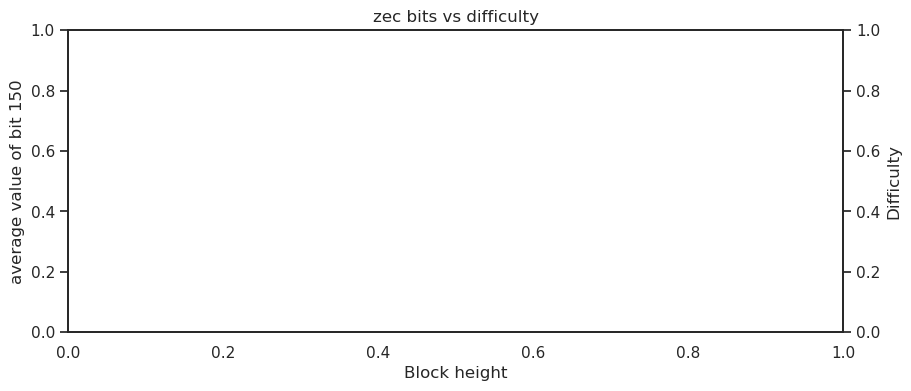

In [33]:
sns.set_style("white")

marker_bit = 150

plt.figure(figsize=(10,4), dpi=100)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Block height")
ax1.set_ylabel(f"average value of bit {marker_bit}")
ax2.set_ylabel("Difficulty")
plt.title("zec bits vs difficulty")
ax1.set_ylim(0, max(zec_bit))
plt.xlim(0, len(zec_bits[marker_bit]))

ax1.plot(zec_bits[marker_bit], color='red', lw=0.5)

ax2.plot(zec_diff, color='black', lw=0.5)
plt.show()

In [37]:
def get_eth_bit_data():
    bits = []
    bitsize = 64
    
    # split nonces into chunks
    for chunk in chunks(nonces["eth"], 10000):
        chunk_bits = [0] * bitsize
        chunk_size = len(chunk)
        for nonce in chunk:
            # transform nonce into bit representation
            binary = to_bits(nonce, bitsize)
            for bit, value in enumerate(binary): 
                # and collect when marker bit is set
                chunk_bits[bit] += value
        
        bits.append([value / chunk_size for value in chunk_bits])
                    
    return transpose(bits)

def get_etc_bit_data():
    bits = []
    bitsize = 64
    
    # split nonces into chunks
    for chunk in chunks(nonces["etc"], 10000):
        chunk_bits = [0] * bitsize
        chunk_size = len(chunk)
        for nonce in chunk:
            # transform nonce into bit representation
            binary = to_bits(nonce, bitsize)
            for bit, value in enumerate(binary): 
                # and collect when marker bit is set
                chunk_bits[bit] += value
        
        bits.append([value / chunk_size for value in chunk_bits])
                    
    return transpose(bits)

eth_bits = get_eth_bit_data()
etc_bits = get_etc_bit_data()

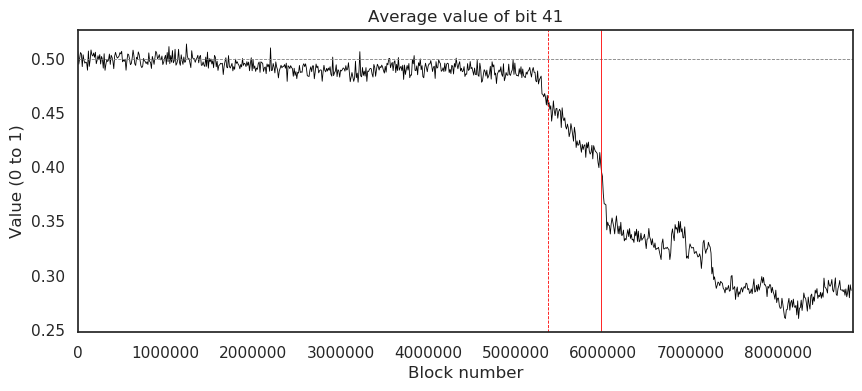

In [38]:
lw = 0.6

plt.plot([x * 10000 for x in range(len(eth_bits[40]))], eth_bits[40], color='black', lw=lw)
plt.xlim([0, 10000 * (len(eth_bits[40]) + 1)])
plt.axhline(0.5, ls='--', color='grey', lw=lw)
plt.axvline(5370000, ls='--', color='red', lw=lw)
plt.axvline(5971679, ls='-', color='red', lw=lw)
plt.xlabel("Block number")
plt.ylabel("Value (0 to 1)")
plt.title("Average value of bit 41")
plt.show()

In [39]:
eth_window = 10000
start = 3500000
end = 8800000

def get_bit_41_frequency(miner):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"""
                SELECT
                    COALESCE(value, 0.5)
                FROM generate_series({start}, {end - 1}, {eth_window}) a
                LEFT JOIN (
                SELECT 
                    number / {eth_window} "n", 
                    AVG(substring(right(nonce::text, -1)::varbit from 41 for 1)::int) "value"
                FROM 
                    ethereum 
                WHERE 
                    ENCODE(miner, 'hex') = '{miner}' 
                AND 
                    number >= {start} AND number < {end} 
                GROUP BY 1 
                HAVING COUNT(*) >= {eth_window / 100}
                ORDER BY 1 ASC 
                ) b
                ON a = n * {eth_window}
                ORDER BY a ASC
            """)
            return list(map(lambda x: float(x[0]), cursor.fetchall()))
        
ethermine = get_bit_41_frequency("ea674fdde714fd979de3edf0f56aa9716b898ec8")
f2pool = get_bit_41_frequency("829bd824b016326a401d083b33d092293333a830")
sparkpool = get_bit_41_frequency("5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c")
nanopool = get_bit_41_frequency("52bc44d5378309ee2abf1539bf71de1b7d7be3b5")
miningpoolhub = get_bit_41_frequency("b2930b35844a230f00e51431acae96fe543a0347")

def get_others_bit_41_frequency():
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"""
                SELECT AVG(substring(right(nonce::text, -1)::varbit from 41 for 1)::int) 
                FROM ethereum 
                WHERE 
                ENCODE(miner, 'hex') != 'ea674fdde714fd979de3edf0f56aa9716b898ec8'
                AND ENCODE(miner, 'hex') != '829bd824b016326a401d083b33d092293333a830'
                AND ENCODE(miner, 'hex') != '5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c'
                AND ENCODE(miner, 'hex') != '52bc44d5378309ee2abf1539bf71de1b7d7be3b5'
                AND ENCODE(miner, 'hex') != 'b2930b35844a230f00e51431acae96fe543a0347'
                AND number >= {start} AND number < {end} 
                GROUP BY number / {eth_window} 
                ORDER BY number / {eth_window} ASC
            """)
            return list(map(lambda x: float(x[0]), cursor.fetchall()))
        
others = get_others_bit_41_frequency()

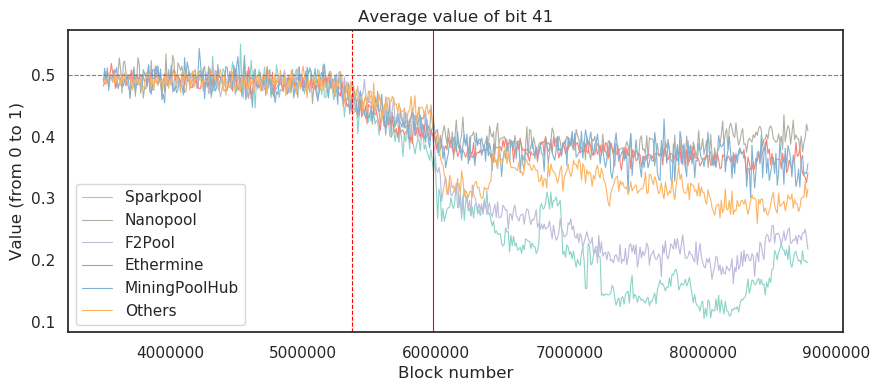

In [40]:
lw = 0.8
xvalues = [start + x * eth_window for x in range(len(sparkpool))]
plt.plot(xvalues, sparkpool, color='#8dd3c7', lw=lw, label='Sparkpool')
plt.plot(xvalues, nanopool, color='#afafa3', lw=lw, label='Nanopool')
plt.plot(xvalues, f2pool, color='#bebada', lw=lw, label='F2Pool')
plt.plot(xvalues, ethermine, color='#fb8072', lw=lw, label='Ethermine')
plt.plot(xvalues, miningpoolhub, color='#80b1d3', lw=lw, label='MiningPoolHub')
plt.plot(xvalues, others, color='#fdb462', lw=lw, label='Others')
plt.axvline(537 * 10000, ls='--', color='red', lw=lw)
plt.axvline(5971679, ls='-', color='red', lw=lw)
plt.xlabel("Block number")
plt.ylabel("Value (from 0 to 1)")
plt.title("Average value of bit 41")
plt.axhline(0.5, ls='--', color='grey', lw=lw)
plt.legend()
plt.show()

In [41]:
def get_bit_41_daily_frequency(chain):
    with psycopg2.connect("postgresql://postgres@localhost:7432/postgres2") as conn:
        with conn.cursor() as cursor:
            cursor.execute(f"""
                SELECT
                    AVG(substring(right(nonce::text, -1)::varbit from 41 for 1)::int) "value"
                FROM 
                    {chain} 
                WHERE
                    DATE_TRUNC('day', '1970-01-01 00:00:00'::timestamp without time zone + "timestamp"::double precision * '00:00:01'::interval) >= '2016-08-01'
                GROUP BY DATE_TRUNC('day', '1970-01-01 00:00:00'::timestamp without time zone + "timestamp"::double precision * '00:00:01'::interval)
                ORDER BY DATE_TRUNC('day', '1970-01-01 00:00:00'::timestamp without time zone + "timestamp"::double precision * '00:00:01'::interval)
            """)
            return list(map(lambda x: float(x[0]), cursor.fetchall()))

eth_freq = get_bit_41_daily_frequency("ethereum")
etc_freq = get_bit_41_daily_frequency("ethereum_classic")

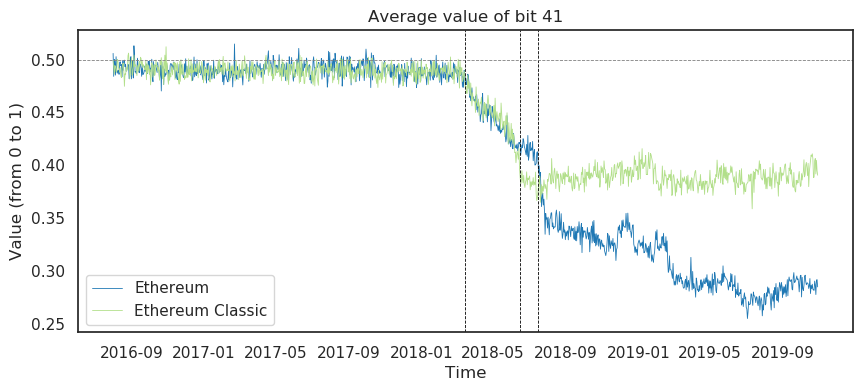

In [84]:
from datetime import datetime, date, timedelta
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()

lw = 0.6
start_day = date(2016, 8, 1)
xvalues = [datetime.combine((start_day + timedelta(days=i)), datetime.min.time()) for i in range(len(eth_freq))]
plt.plot(xvalues, eth_freq, color='#1f78b4', lw=lw, label='Ethereum')
plt.plot(xvalues, etc_freq, color='#b2df8a', lw=lw, label='Ethereum Classic')
plt.axvline(datetime(2018, 3, 15), color='black', ls='--', lw=lw)
plt.axvline(datetime(2018, 6, 15), color='black', ls='--', lw=lw)
plt.axvline(datetime(2018, 7, 16), color='black', ls='--', lw=lw)
plt.axhline(0.5, color='grey', ls='--', lw=lw)
plt.title("Average value of bit 41")
plt.xlabel("Time")
plt.ylabel("Value (from 0 to 1)")
plt.legend()
plt.show()

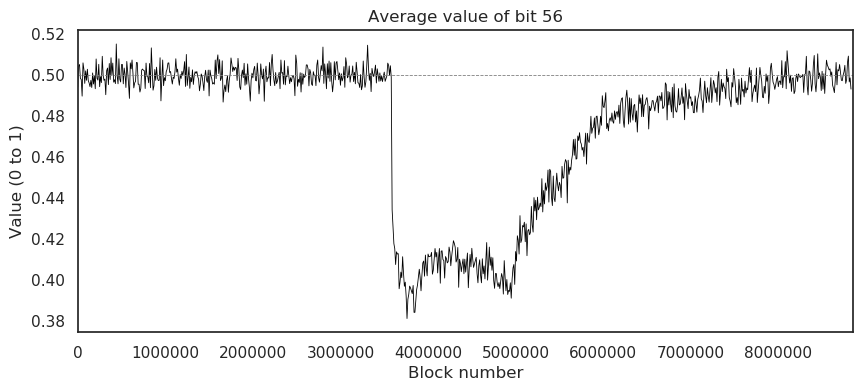

In [43]:
lw = 0.6

bit = 55
plt.plot([x * 10000 for x in range(len(eth_bits[bit]))], eth_bits[bit], color='black', lw=lw)
plt.xlim([0, 10000 * (len(eth_bits[bit]) + 1)])
plt.axhline(0.5, ls='--', color='grey', lw=lw)
plt.xlabel("Block number")
plt.ylabel("Value (0 to 1)")
plt.title(f"Average value of bit {bit + 1}")
plt.show()

In [49]:
sample_nonces = nonces["eth"][-150000:]
len(sample_nonces)

150000

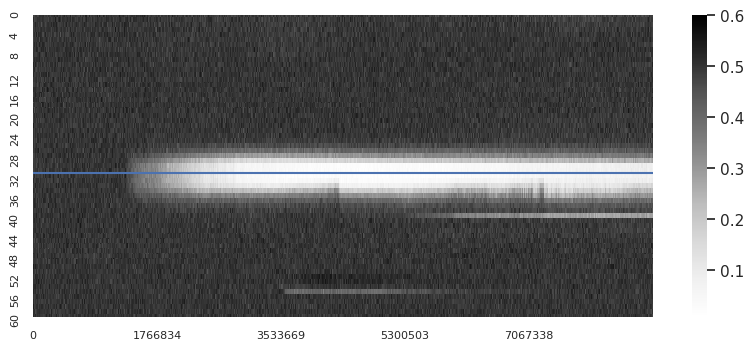

In [85]:
heatmap(nonces["eth"], 1000, 64)
plt.axhline(32)
plt.show()

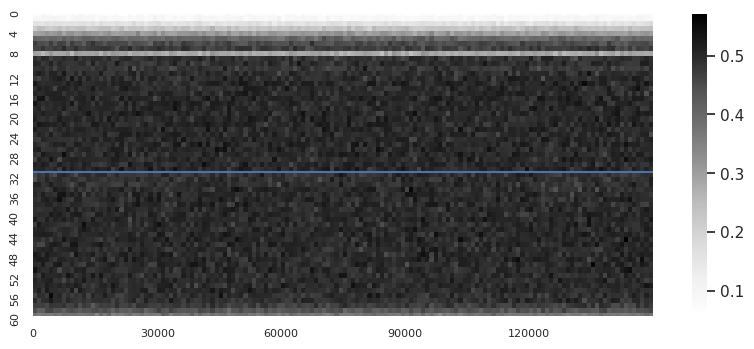

In [80]:
import struct


# interpret a 64bits int into 2 32 bits word
# flip the top one and put them back together
def flip_words(nonce):
    nonce_bytes = nonce.to_bytes(8, signed=False, byteorder="big")
    top_word = nonce_bytes[:4]
    bottom_word = nonce_bytes[4:]
    flipped = bottom_word + top_word
    return int.from_bytes(flipped, byteorder="big", signed=False)
    
flipped = list(map(lambda x: flip_words(x), sample_nonces))
plt.xlim(0, 63)
heatmap(flipped, 1000, 64)
plt.axhline(32)